In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import concurrent.futures
import numpy as np

In [2]:
# Load data
file_path = "/Users/daniellott2/Documents/stock-program/stocks_calc_final.csv"
df = pd.read_csv(file_path)

In [3]:
# Descriptive Statistics
print("\nDescriptive statistics of the dataset:")
print(df.describe())


Descriptive statistics of the dataset:
               Open          High           Low         Close  Adjusted Close  \
count  3.754357e+06  3.754357e+06  3.754357e+06  3.754357e+06    3.754357e+06   
mean   8.143941e+01  8.240278e+01  8.045152e+01  8.145065e+01    6.715605e+01   
std    1.867656e+02  1.888396e+02  1.846871e+02  1.868087e+02    2.139462e+02   
min    1.000000e-04  1.000000e-04  1.000000e-04  1.000000e-04    1.000000e-04   
25%    2.734000e+01  2.774000e+01  2.693000e+01  2.734000e+01    1.491977e+01   
50%    4.645000e+01  4.700000e+01  4.585000e+01  4.645000e+01    3.013736e+01   
75%    7.956000e+01  8.040000e+01  7.870000e+01  7.958000e+01    6.158000e+01   
max    9.839980e+03  9.912560e+03  9.768290e+03  9.892300e+03    1.185921e+04   

             Volume  Dividend Amount  Split Coefficient      Earnings  \
count  3.754357e+06     3.754357e+06       3.754357e+06  3.177794e+06   
mean   4.138245e+06     5.089995e-03       1.000215e+00  1.234860e+00   
std    1.31

In [7]:
# Sample the data (e.g., 10% of the data)
df_sampled = df.sample(frac=1, random_state=42)

In [8]:
# Feature engineering and data preparation function
def prepare_features(df):
    df['Price_Change_1Y'] = (df['Adjusted Close'].shift(-252) - df['Adjusted Close']) / df['Adjusted Close']
    df['Price_Change_5Y'] = (df['Adjusted Close'].shift(-252*5) - df['Adjusted Close']) / df['Adjusted Close']
    df['Price_Change_10Y'] = (df['Adjusted Close'].shift(-252*10) - df['Adjusted Close']) / df['Adjusted Close']
    return df.dropna()

In [9]:
# Use multithreading for data preparation
with concurrent.futures.ThreadPoolExecutor() as executor:
    future = executor.submit(prepare_features, df_sampled)
    df = future.result()

In [10]:
# Filter data to include only relevant columns and ignore negative P/E ratios and P/E ratios >= 100
df = df[['P/E Ratio', 'Price_Change_1Y', 'Price_Change_5Y', 'Price_Change_10Y']]
df = df[(df['P/E Ratio'] >= 0) & (df['P/E Ratio'] < 100)]

In [11]:
# Remove rows with missing or infinite P/E ratios
df = df.replace([np.inf, -np.inf], np.nan).dropna()

In [12]:
# Function to calculate mean return for a given P/E ratio range
def calculate_mean_return(df, lower, upper, period):
    filtered_df = df[(df['P/E Ratio'] >= lower) & (df['P/E Ratio'] < upper)]
    if not filtered_df.empty:
        return filtered_df[period].mean()
    else:
        return -np.inf  # Return negative infinity if no data points in the range

In [13]:
# Function to find the optimal P/E ratio range for a given period
def find_optimal_range(df, period):
    best_mean_return = -np.inf
    best_range = (0, 0)

    for lower in np.arange(0, 30, 0.1):
        for upper in np.arange(lower + 0.1, 30.1, 0.1):
            filtered_df = df[(df['P/E Ratio'] >= lower) & (df['P/E Ratio'] < upper)]
            percent_in_range = len(filtered_df) / len(df) * 100
            if percent_in_range > 1:
                mean_return = calculate_mean_return(df, lower, upper, period)
                if mean_return > best_mean_return:
                    best_mean_return = mean_return
                    best_range = (lower, upper)

    return best_range, best_mean_return

In [14]:
# Calculate the percentage of data with P/E ratio in the range 0-5
pe_ratio_0_5 = df[(df['P/E Ratio'] >= 0) & (df['P/E Ratio'] < 5)]
percent_0_5 = len(pe_ratio_0_5) / len(df) * 100
print(f"Percentage of data with P/E ratio in the range 0-5: {percent_0_5:.2f}%")

Percentage of data with P/E ratio in the range 0-5: 0.40%


In [15]:
# Find optimal ranges for 1-year, 5-year, and 10-year periods
optimal_range_1Y, best_mean_return_1Y = find_optimal_range(df, 'Price_Change_1Y')
print(f"Optimal P/E Ratio range for 1-year gains: {optimal_range_1Y} with mean return: {best_mean_return_1Y}")

Optimal P/E Ratio range for 1-year gains: (np.float64(0.0), np.float64(8.3)) with mean return: 15.851671426514178


In [16]:
optimal_range_5Y, best_mean_return_5Y = find_optimal_range(df, 'Price_Change_5Y')
print(f"Optimal P/E Ratio range for 5-year gains: {optimal_range_5Y} with mean return: {best_mean_return_5Y}")


Optimal P/E Ratio range for 5-year gains: (np.float64(0.30000000000000004), np.float64(8.499999999999998)) with mean return: 15.797037988154552


In [17]:
optimal_range_10Y, best_mean_return_10Y = find_optimal_range(df, 'Price_Change_10Y')
print(f"Optimal P/E Ratio range for 10-year gains: {optimal_range_10Y} with mean return: {best_mean_return_10Y}")

Optimal P/E Ratio range for 10-year gains: (np.float64(15.700000000000001), np.float64(16.999999999999996)) with mean return: 18.33305496224072


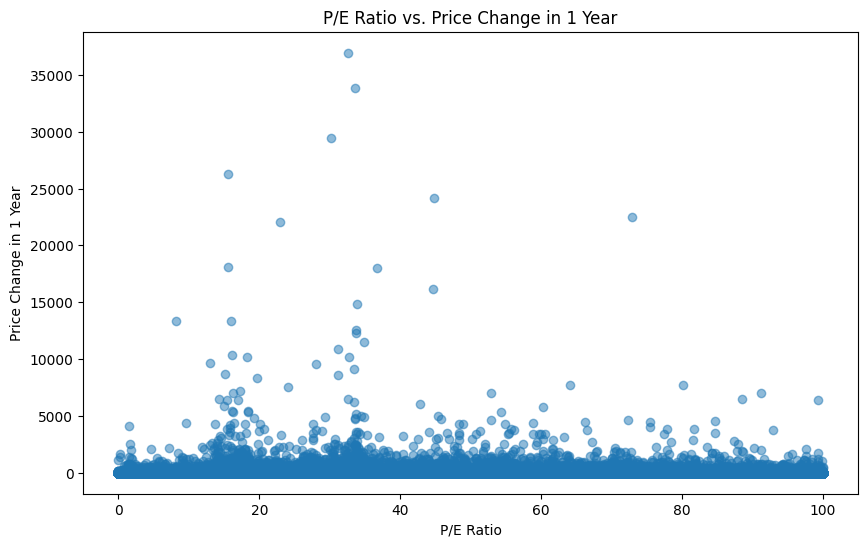

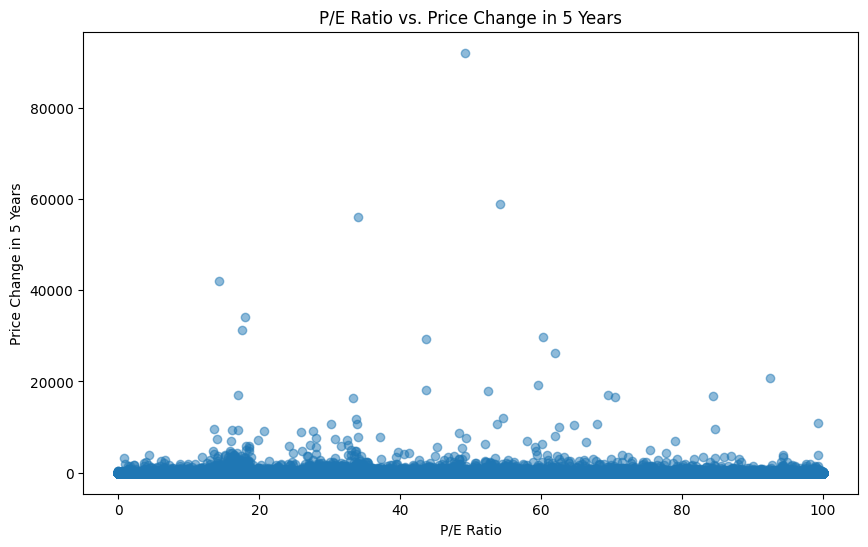

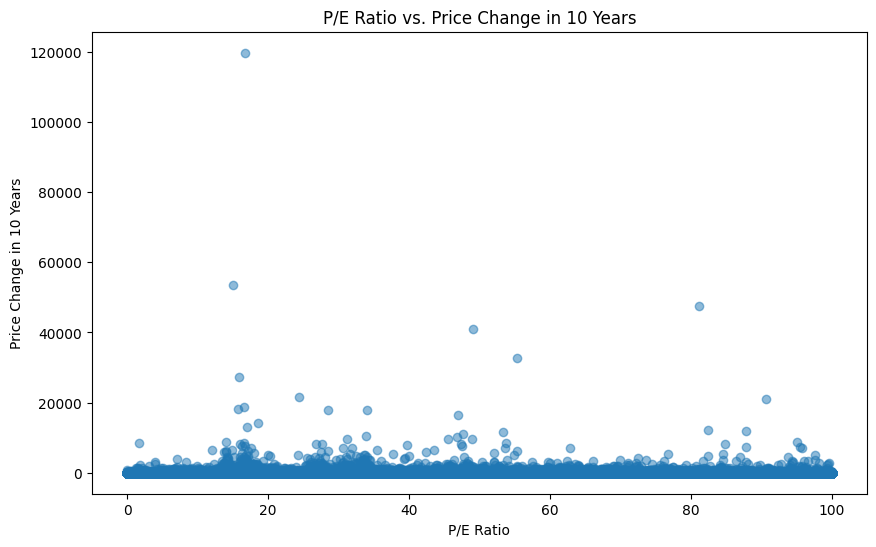

/var/folders/wm/fydrjt2543sch7051n5t7ygc0000gs/T/ipykernel_33472/260925575.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby('PE_Bin')['Price_Change_5Y'].mean()


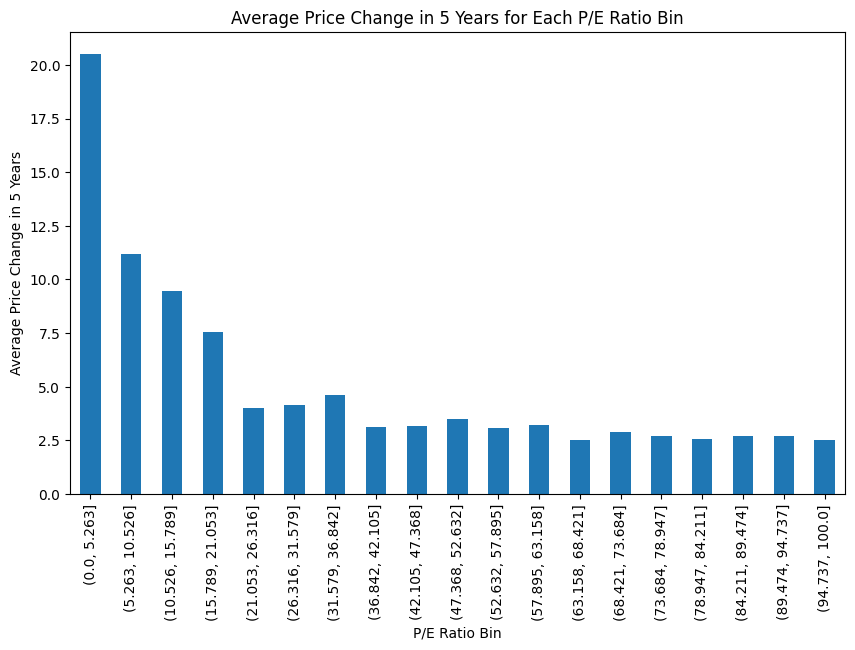

In [18]:
# Plot P/E Ratio vs. Price Change in 1 Year
plt.figure(figsize=(10, 6))
plt.scatter(df['P/E Ratio'], df['Price_Change_1Y'], alpha=0.5)
plt.xlabel("P/E Ratio")
plt.ylabel("Price Change in 1 Year")
plt.title("P/E Ratio vs. Price Change in 1 Year")
plt.show()

# Plot P/E Ratio vs. Price Change in 5 Years
plt.figure(figsize=(10, 6))
plt.scatter(df['P/E Ratio'], df['Price_Change_5Y'], alpha=0.5)
plt.xlabel("P/E Ratio")
plt.ylabel("Price Change in 5 Years")
plt.title("P/E Ratio vs. Price Change in 5 Years")
plt.show()

# Plot P/E Ratio vs. Price Change in 10 Years
plt.figure(figsize=(10, 6))
plt.scatter(df['P/E Ratio'], df['Price_Change_10Y'], alpha=0.5)
plt.xlabel("P/E Ratio")
plt.ylabel("Price Change in 10 Years")
plt.title("P/E Ratio vs. Price Change in 10 Years")
plt.show()

# Plot the average 5-year price change for each P/E ratio bin
plt.figure(figsize=(10, 6))
bins = np.linspace(df['P/E Ratio'].min(), df['P/E Ratio'].max(), 20)
df['PE_Bin'] = pd.cut(df['P/E Ratio'], bins)
bin_means = df.groupby('PE_Bin')['Price_Change_5Y'].mean()
bin_means.plot(kind='bar')
plt.xlabel("P/E Ratio Bin")
plt.ylabel("Average Price Change in 5 Years")
plt.title("Average Price Change in 5 Years for Each P/E Ratio Bin")
plt.show()

In [2]:

import pandas as pd
from sklearn.linear_model import LinearRegression

df = pd.read_csv("../stocks_with_1yr_price_change.csv")

# Take a 10% sample
df_sample = df.sample(frac=0.1, random_state=42)

# Prepare features (X) and target (y)
X = df_sample[["Adjusted Close", "Volume", "P/E (ttm)", "MA_50", "MA_200"]]
y = df_sample["Price_Change_1Y"]

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Print results
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R^2 Score:", model.score(X, y))


Coefficients: [ 1.17282194e-05 -1.35188653e-09  5.77971774e-21  1.15958627e-05
  1.12060731e-05]
Intercept: 0.1772379302986856
R^2 Score: 0.0008896238744323659
